# 전기전자 심화 설계 #7

> - 담당교수 : 조용범 교수님
> - 실험날짜 : 2023.09.07
> - 조 : 9조
> - 조원
>   201910853 박준영  
>   202014122 김진구  
>   202110965 이관호  

1. **Title** : Utilizing pre-trained models
2. **Name**  
<17조>  
201910853 박준영  
202014122 김진구  
202110965 이관호
3. **Abstract && Background**  
    1. 사전 학습 모델
        사전 학습 모델이란 '이미 학습된 모델'을 의미한다. 모델을 매번 초기 상태에서 학습시키는 것은 상당한 시간이 소요되므로, 웬만한 CNN모델들은 PyTorch에서 이미 학습된 상태로 제공된다.  
        사전 학습 모델을 효과적으로 사용하는 방법은 이번에 알아볼 '전이 학습'과 '파인 튜닝'으로 나누어 진다.
    2. 전이학습 (Transfer Learning)
        '전이 학습'이란 모델의 파라미터들 가운데 입력에 가까운 부분의 레이어 함수는 모두 고정해 둔 채로, 출력에 가까운 레이어들만 다시 학습시키는 방법이다.  
        이미 신경망의 층마다 어디에 집중해야 하는지 알고 있다는 점에서 전이 학습은 가능하다. ImageNet등의 큰 데이터셋을 학습한 모델은 다른 작업에 전이하여, 더 작은 데이터로도 계산 효율을 낼 수 있는 것이다. 전이 학습은 모델의 다른 부분은 그대로 두되 모델의 출력 단과 가까운 레이어들만 수정하거나 교체하는 식으로 구현할 수 있다.
    3. 파인 튜닝 (Fine-tuning)
        파인 튜닝은 사전 학습된 모델의 파라미터를 초깃값으로 사용하되, 모든 레이어 함수를 사용해 학습하는 방법이다. 학습 방식을 유지한다는 점에서 인간의 학습 방식과 상당히 유사한데, 강의자료에서의 예시를 빌려 쓰자면, '전자회로1'을 우수한 성적으로 수강한 학생이라면, '전자회로2'과목을 수강할 때 그렇지 않은 학생들보다 우수한 성적을 받을 확률이 높은 것과 같은 원리이다. 이미지 분류에서 잘 훈련된 모델은 다른 이미지 분류 작업을 학습할 때 기존의 지식을 활용하므로 세부적인 부분을 더 학습할 수 있게 되는 것이다.  
        파인튜닝은 parameter gradient를 false로 두지 않고, 마지막의 출력 부분만 데이터에 맞춰 바꿔 주면 구현할 수 있다.
    4. 전이학습 VS 파인튜닝
        그렇다면 전이학습과 파인튜닝은 각각 어떤 상황에서 적합한가? 알려진 바로는, 학습시킬 데이터가 작다면 전이 학습을 선택하는 것이 유리하고, 그렇지 않다면 파인튜닝이 유리하다고 한다. 그렇지만 이것은 대략적인 경향성일 뿐, 확실한 사실은 아니다. 따라서 어떤 방식이 더 유리한지는 실험적으로 판단해 볼 필요가 있다.
    5. 사전 학습 모델은 언제 필요한가?
        - 시간과 자원의 부족
            모델을 처음부터 학습시키기 위해서는 많은 시간과 자원이 필요하다. 일정 기대값 이상의 학습 효과를 보려면 충분히 많은 데이터가 필요한데, 이만큼의 데이터를 구하기 힘들 수 있다. 또, 모델을 처음부터 학습시키면 많은 연산량과 시간이 필요하다.
            기존에 비슨한 문제에 대해 학습된 모델의 지식을 활용하면, 적은양의 데이터로도 효과적인 학습을 할 수 있다.
        - 특정 클래스의 데이터가 부족한 경우
            데이터 중 일부 클래스의 데이터가 다른 클래스보다 훨씬 적을 경우, 모델은 그 클래스를 제대로 인식하지 못할 수 있다. 예를 들어, 특정 질병에 대한 데이터가 부족한 경우, 다양한 질병을 학습한 모델을 활용하면 드문 질병에 대한 인식률을 향상시킬 수 있다.
        - 데이터의 분포가 균일하지 않은 경우
            위와 다르게 특정 이미지의 데이터만이 지나치게 많은 경우가 있다. 사람 얼굴을 인식하는 테스트에서 동양인의 얼굴만 학습을 한 모델은 다른 인종의 얼굴을 구분할 수 없는 문제를 야기할 수 있다. 그러나 이미 서양인의 얼굴을 학습해 둔 모델에 전이 학습한다면, 다양한 인종의 얼굴을 인식하는 성능을 향상시킬 수 있다.
      
  
4. **Experimental Results**  

# 1. 예제
### Source Code && DATA

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

### 데이터 불러오기
데이터를 다음의 링크에서 다운로드받아 현재 디렉토리에 압축을 해제하여 준다.  
[https://download.pytorch.org/tutorial/hymenoptera_data.zip](https://download.pytorch.org/tutorial/hymenoptera_data.zip)



In [4]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 일부 이미지 시각화하기
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화

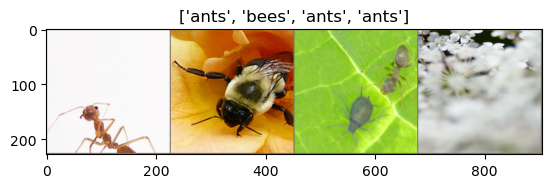

In [5]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 모델 학습하기

이제 모델을 학습하기 위한 일반 함수를 작성.

-  학습률(learning rate) 관리(scheduling)
-  최적의 모델 구하기

아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러 객체(Object)이다.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

#### 모델 예측값 시각화하기

일부 이미지에 대한 예측값을 보여주는 일반화된 함수.




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 합성곱 신경망 미세조정(finetuning)

미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화.




In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/vnla/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.14MB/s]


#### 학습 및 평가하기

CPU에서는 15-25분 가량, GPU에서는 1분도 이내의 시간이 소요됨




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5873 Acc: 0.7459
val Loss: 0.2483 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5459 Acc: 0.7951
val Loss: 0.4375 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.5882 Acc: 0.7623
val Loss: 0.3067 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.4331 Acc: 0.8156
val Loss: 0.2124 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.7312 Acc: 0.7705
val Loss: 0.6507 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.6206 Acc: 0.7992
val Loss: 1.2278 Acc: 0.7582

Epoch 6/24
----------
train Loss: 0.8516 Acc: 0.7787
val Loss: 0.5503 Acc: 0.8105

Epoch 7/24
----------
train Loss: 0.5374 Acc: 0.8033
val Loss: 0.3269 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.4261 Acc: 0.8238
val Loss: 0.3525 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3886 Acc: 0.8607
val Loss: 0.2786 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3704 Acc: 0.8566
val Loss: 0.2502 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2444 Acc: 0.9016
val Loss: 0.2624 Acc: 0.9020

Ep

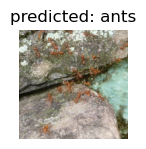

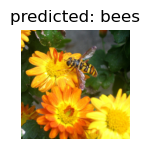

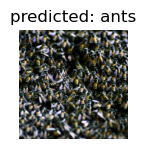

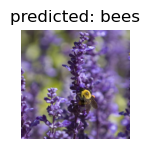

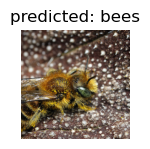

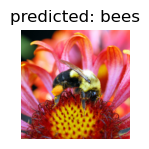

In [10]:
visualize_model(model_ft)

### 고정된 특징 추출기로써의 합성곱 신경망
여기서는 마지막 계층을 제외한 신경망의 모든 부분을 고정해 주는데,  
``requires_grad = False`` 로 설정하여 매개변수를 고정하여 ``backward()`` 중에
경사도가 계산되지 않도록 해야 한다.

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### 학습 및 평가하기


In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6327 Acc: 0.6352
val Loss: 0.2291 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5963 Acc: 0.7336
val Loss: 0.1598 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4038 Acc: 0.8238
val Loss: 0.1840 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5567 Acc: 0.8074
val Loss: 0.1595 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4456 Acc: 0.7992
val Loss: 0.1811 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3865 Acc: 0.8238
val Loss: 0.1898 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5194 Acc: 0.7992
val Loss: 0.1937 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4423 Acc: 0.8033
val Loss: 0.2131 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3721 Acc: 0.8402
val Loss: 0.1958 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3435 Acc: 0.8238
val Loss: 0.2045 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4142 Acc: 0.7951
val Loss: 0.1953 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3206 Acc: 0.8443
val Loss: 0.1804 Acc: 0.9542

Ep

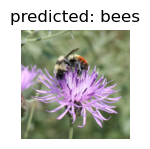

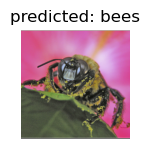

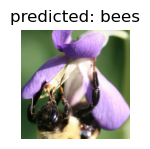

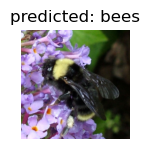

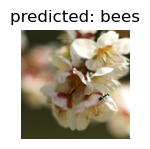

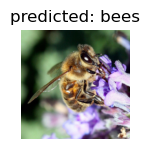

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# 2. 과제
### Source Code && DATA

In [14]:
model_conv = torchvision.models.googlenet(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=1e-3, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /home/vnla/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:04<00:00, 11.0MB/s]


In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6206 Acc: 0.6230
val Loss: 0.4009 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5420 Acc: 0.7418
val Loss: 0.3463 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4819 Acc: 0.7500
val Loss: 0.3473 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4198 Acc: 0.8115
val Loss: 0.2435 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3699 Acc: 0.8279
val Loss: 0.2265 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4289 Acc: 0.8074
val Loss: 0.2345 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.5549 Acc: 0.7336
val Loss: 0.2119 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3809 Acc: 0.8361
val Loss: 0.2127 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3428 Acc: 0.8607
val Loss: 0.2149 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3697 Acc: 0.8443
val Loss: 0.2059 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4008 Acc: 0.8156
val Loss: 0.1975 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3933 Acc: 0.8115
val Loss: 0.2067 Acc: 0.9346

Ep

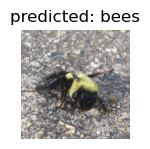

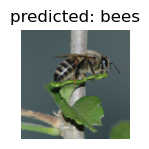

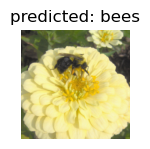

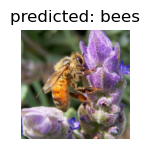

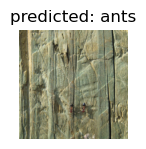

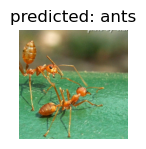

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Discussion
ResNet18은 18개의 Residual Block Layer를 의미한다. 지나치게 많은 Layer간의 연산은 성능 저하를 야기하는, 이른바 Gradient Vanishing 현상이 수 차례 실험적으로 관찰되었고, 이를 해결하고자 고안된 것이 Residual Block이다. 이는 조건에 따라 Layer 의 연산을 하거나 하지 않는 것으로, Skip Connection을 의미한다. 따라서 Gradient Vanishing 현상에 대한 효과적인 해결 방안이다.  
GoogLeNet은 ILSVRC-2014에서 우승한 CNN Network로, Inception module을 쌓은 형태로 구현된 네트워크이다. 보다 효과적인 네트워크 구현을 위해 고안된 네트워크이며, AlexNet보다는 그 형태가 더 깊지만 파라미터의 수는 무려 1/12수준이다. 그러나 뛰어난 성능의 이면에는 적용 범위에 대한 한계, 사용 단계에서의 어려움 등의 단점들이 존재했고, 따라서 실제 활용되는 빈도는 그리 크지 않다.  
Depth의 증가와 Width의 증가는 Overfitting이 발생하기 쉽고, 많은 연산 자원을 활용한다는 단점을 GoogLeNet은 Weight의 대부분을 0으로 만드는 Sparse한 형태의 네트워크를 큰 구조로 만들어 해결했다.

5. **Conclusion**  
    이번 주차에서는 사전 학습 모델에 대한 다양한 지식과 더불어 여러 모델을 활용해 보며 실습하는 시간을 가질 수 있었다. 전이 학습과 파인 튜닝에 대해 조사하고, 수업 시간 이외에도 여러 모델들을 활용하며 다양한 실습을 해 가며 각 네트워크들의 장단점을 비교해 볼 수 있는 시간이었다.

6. **References**  
""